In [175]:
import requests, bs4, re
from bs4 import BeautifulSoup as bs
import time
from datetime import datetime
from IPython.core.display import display, HTML
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn.linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

In [106]:
#loading top box office release of 2021
url ='https://www.boxofficemojo.com/release/rl2869659137/'
page = requests.get(url).text
#request HTML and create as beautifulsoup object
soup = bs(page)

In [7]:
#take a look at HTML
print(page[:1000])

<!doctype html><html class="a-no-js" data-19ax5a9jf="dingo"><head><script>var aPageStart = (new Date()).getTime();</script><meta charset="utf-8"/>
<script type='text/javascript'>var ue_t0=ue_t0||+new Date();</script>
<script type='text/javascript'>
window.ue_ihb = (window.ue_ihb || window.ueinit || 0) + 1;
if (window.ue_ihb === 1) {

var ue_csm = window,
    ue_hob = +new Date();
(function(d){var e=d.ue=d.ue||{},f=Date.now||function(){return+new Date};e.d=function(b){return f()-(b?0:d.ue_t0)};e.stub=function(b,a){if(!b[a]){var c=[];b[a]=function(){c.push([c.slice.call(arguments),e.d(),d.ue_id])};b[a].replay=function(b){for(var a;a=c.shift();)b(a[0],a[1],a[2])};b[a].isStub=1}};e.exec=function(b,a){return function(){try{return b.apply(this,arguments)}catch(c){ueLogError(c,{attribution:a||"undefined",logLevel:"WARN"})}}}})(ue_csm);


    var ue_err_chan = 'jserr-rw';
(function(d,e){function h(f,b){if(!(a.ec>a.mxe)&&f){a.ter.push(f);b=b||{};var c=f.logLevel||b.logLevel;c&&c!==k&&c!==m&&c!=

In [62]:
#display(HTML(page))

In [8]:
#Locate title of movie
title = soup.find('h1').text
title

'Spider-Man: No Way Home'

In [9]:
#Look at text content extracted from HTML
for item in soup.find_all('span'):
    print(item.text)
    
#spantext = soup.find_all('span')












                            Brand rankings
                        



                            Brand rankings
                        



                            Franchise rankings
                        



                            Franchise rankings
                        



                            Genre keyword rankings
                        



                            Genre keyword rankings
                        
 Title Summary
All ReleasesOriginal Release




All TerritoriesDomesticArgentinaAustraliaBoliviaBrazilBulgariaColombiaCroatiaCzech RepublicEcuadorEgyptFranceGermanyHong KongHungaryIcelandIndiaIndonesiaIsraelItalyJapanKuwaitLithuaniaMalaysiaMexicoNetherlandsNew ZealandNorwayPeruPhilippinesPortugalRomaniaRussia/CISSaudi ArabiaSerbia and MontenegroSlovakiaSloveniaSouth AfricaSouth KoreaSpainTaiwanThailandTurkeyUkraineUnited Arab EmiratesUnited KingdomVietnam





                        
                            
                       

In [10]:
#extract target variable (worldwide gross) from webpage
worldwide_gross = soup.find_all(class_ = 'money')[2].text
#remove dollar sign and commas
worldwide_gross = worldwide_gross.replace("$", "")
worldwide_gross = worldwide_gross.replace(",", "")
#change type to float
worldwide_gross = float(worldwide_gross)
worldwide_gross

1866988921.0

In [11]:
#extract percent domestic feature
percent_domestic = soup.find(text = re.compile('%'))
#remove percent symbol
percent_domestic = percent_domestic.replace("%", "")
#change type to float
percent_domestic = float(percent_domestic)
percent_domestic

42.2

In [12]:
#extract distributor
distributor = soup.find(text = re.compile('Distributor')).next.text
#split and take first string: we don't need to see full information
distributor = distributor.split("See full")
distributor = distributor[0]
distributor

'Sony Pictures Entertainment (SPE)'

In [13]:
#extract release date
release_date = soup.find(text = re.compile('Release Date')).next.text
#change to datetime type
release_date = datetime.strptime(release_date, '%b %d, %Y')
release_date = datetime.date(release_date)
print(release_date)


2021-12-17


In [14]:
#extract MPAA rating
#note: many films are not rated and this accounts for a lot of eliminated nulls
MPAA = soup.find(text = re.compile('MPAA')).next.text
MPAA

'PG-13'

In [15]:
#collects runtime, transforms from hours and minutes to total minutes
runtime = soup.find(text = re.compile('Running Time')).next.text
runtime = runtime.split("hr")
runtime_hrs = runtime[0]
runtime_hrs = float(runtime_hrs)
runtime_mins = runtime[1]
runtime_mins = runtime_mins.split("min")
runtime_mins = runtime_mins[0]
runtime_mins = float(runtime_mins)
runtime = 60*runtime_hrs + runtime_mins
runtime


148.0

In [16]:
#collects list of genres
#splits items in list, strips spaces
genres = soup.find(text = re.compile('Genres')).next.text
genres = genres.split("\n")
#procedures for cleaning up genres lists comes from:
#https://tutorial.eyehunts.com/python/how-to-remove-space-in-list-python-example-code/
genres = [x.strip(' ') for x in genres]
genres = [ele for ele in genres if ele.strip()]
genres

['Action', 'Adventure', 'Fantasy', 'Sci-Fi']

In [17]:
#number of days in release
in_release = soup.find(text = re.compile('In Release')).next.text
in_release = in_release.split("days")
in_release = in_release[0]
#change type to float
in_release  = float(in_release)
in_release 

82.0

In [18]:
#highest number of theatres showing the movie
widest_release = soup.find(text = re.compile('Widest Release')).next.text
widest_release = widest_release.split("theaters")
widest_release = widest_release[0]
widest_release = widest_release.replace(",", "")
#change type to float
widest_release = float(widest_release)
widest_release

4336.0

General case function. Takes url as argument and uses same methods as before. Stores feature information as a dictionary:

In [28]:
def extract_info(url):
    url = url
    page = requests.get(url).text
    soup = bs(page)
    title = soup.find('h1').text
    
    worldwide_gross = soup.find_all(class_ = 'money')[2].text
    worldwide_gross = worldwide_gross.replace("$", "")
    worldwide_gross = worldwide_gross.replace(",", "")
    worldwide_gross = float(worldwide_gross)
    
    percent_domestic = soup.find(text = re.compile('%'))
    percent_domestic = percent_domestic.replace("%", "")
    percent_domestic = float(percent_domestic)
    
    distributor = soup.find(text = re.compile('Distributor')).next.text
    distributor = distributor.split("See full")
    distributor = distributor[0]
    
    release_date = soup.find(text = re.compile('Release Date')).next.text
    #splitting release date by \n makes it possible to extract data from film with range of release dates
    #eg. 'https://www.boxofficemojo.com/release/rl1908310529/'
    release_date = release_date.split("\n")
    release_date = release_date[0]
    release_date = datetime.strptime(release_date, '%b %d, %Y')
    release_date = datetime.date(release_date)
    
    MPAA = soup.find(text = re.compile('MPAA')).next.text
    
    runtime = soup.find(text = re.compile('Running Time')).next.text
    runtime = runtime.split("hr")
    runtime_hrs = runtime[0]
    runtime_hrs = float(runtime_hrs)
    runtime_mins = runtime[1]
    runtime_mins = runtime_mins.split("min")
    runtime_mins = runtime_mins[0]
    runtime_mins = float(runtime_mins)
    runtime = 60*runtime_hrs + runtime_mins
    
    genres = soup.find(text = re.compile('Genres')).next.text
    genres = genres.split("\n")
    genres = [x.strip(' ') for x in genres]
    genres = [ele for ele in genres if ele.strip()]
    
    in_release = soup.find(text = re.compile('In Release')).next.text
    in_release = in_release.split("days")
    in_release = in_release[0]
    in_release  = float(in_release)
    
    widest_release = soup.find(text = re.compile('Widest Release')).next.text
    widest_release = widest_release.split("theaters")
    widest_release = widest_release[0]
    widest_release = widest_release.replace(",", "")
    widest_release = float(widest_release)
    

    headers = ['title', 'worldwide gross', 'percent domestic', 'distributor', 'release date', 'MPAA rating',
           'runtime (mins)', 'genres', 'time in release', 'widest release']

    movie_dict = dict(zip(headers, [title,
                                    worldwide_gross,
                                    percent_domestic,
                                    distributor,
                                    release_date,
                                    MPAA,
                                    runtime,
                                    genres,
                                    in_release, 
                                    widest_release]))
    
    return movie_dict    


In [29]:
#proof of concept
extract_info('https://www.boxofficemojo.com/release/rl1908310529/')

{'title': 'Venom: Let There Be Carnage',
 'worldwide gross': 502050366.0,
 'percent domestic': 42.5,
 'distributor': 'Sony Pictures Entertainment (SPE)',
 'release date': datetime.date(2021, 10, 1),
 'MPAA rating': 'PG-13',
 'runtime (mins)': 97.0,
 'genres': ['Action', 'Adventure', 'Sci-Fi', 'Thriller'],
 'time in release': 159.0,
 'widest release': 4225.0}

In [159]:
#creates a data frame out of multiple dictionaries
#in this case the top three highest-grossing movies of 2021
movie_data = []
movie_data.append(extract_info('https://www.boxofficemojo.com/release/rl2869659137/'))
movie_data.append(extract_info('https://www.boxofficemojo.com/release/rl3490022913/'))
movie_data.append(extract_info('https://www.boxofficemojo.com/release/rl1908310529/'))
movie_data
df = pd.DataFrame(movie_data)
display(df)

,title,worldwide gross,percent domestic,distributor,release date,MPAA rating,runtime (mins),genres,time in release,widest release
0,Spider-Man: No Way Home,1.867811e+09,42.2,Sony Pictures Entertainment (SPE),2021-12-17,PG-13,148.0,"[Action, Adventure, Fantasy, Sci-Fi]",84.0,4336.0
1,Shang-Chi and the Legend of the Ten Rings,4.322433e+08,51.9,Walt Disney Studios Motion Pictures,2021-09-03,PG-13,132.0,"[Action, Adventure, Fantasy, Sci-Fi]",189.0,4300.0
2,Venom: Let There Be Carnage,5.020504e+08,42.5,Sony Pictures Entertainment (SPE),2021-10-01,PG-13,97.0,"[Action, Adventure, Sci-Fi, Thriller]",161.0,4225.0


In [177]:
#Aim is to create a list of urls for the top 200 films for each of the last ten years:

parent_url ='https://www.boxofficemojo.com/year/2021/?grossesOption=totalGrosses'
parent_url2 ='https://www.boxofficemojo.com/year/2020/?grossesOption=totalGrosses'
parent_url3 ='https://www.boxofficemojo.com/year/2019/?grossesOption=totalGrosses'
parent_url4 ='https://www.boxofficemojo.com/year/2018/?grossesOption=totalGrosses'
parent_url5 ='https://www.boxofficemojo.com/year/2017/?grossesOption=totalGrosses'
parent_url6 ='https://www.boxofficemojo.com/year/2016/?grossesOption=totalGrosses'
parent_url7 ='https://www.boxofficemojo.com/year/2015/?grossesOption=totalGrosses'
parent_url8 ='https://www.boxofficemojo.com/year/2014/?grossesOption=totalGrosses'
parent_url9 ='https://www.boxofficemojo.com/year/2013/?grossesOption=totalGrosses'
parent_url10 ='https://www.boxofficemojo.com/year/2012/?grossesOption=totalGrosses'

#collecting HTML for each of the yearly lists:

parent_page = requests.get(parent_url).text
parent_soup = bs(parent_page)

parent_page2 = requests.get(parent_url2).text
parent_soup2 = bs(parent_page2)

parent_page3 = requests.get(parent_url3).text
parent_soup3 = bs(parent_page3)

parent_page4 = requests.get(parent_url4).text
parent_soup4 = bs(parent_page4)

parent_page5 = requests.get(parent_url5).text
parent_soup5 = bs(parent_page5)

parent_page6 = requests.get(parent_url6).text
parent_soup6 = bs(parent_page6)

parent_page7 = requests.get(parent_url7).text
parent_soup7 = bs(parent_page7)

parent_page8 = requests.get(parent_url8).text
parent_soup8 = bs(parent_page8)

parent_page9 = requests.get(parent_url9).text
parent_soup9 = bs(parent_page9)

parent_page10 = requests.get(parent_url10).text
parent_soup10 = bs(parent_page10)


#make parent_soup out of each year
    
parent_release = parent_soup.find_all(href = re.compile('/release/'))
parent_release2 = parent_soup2.find_all(href = re.compile('/release/'))
parent_release3 = parent_soup3.find_all(href = re.compile('/release/'))
parent_release4 = parent_soup4.find_all(href = re.compile('/release/'))
parent_release5 = parent_soup5.find_all(href = re.compile('/release/'))
parent_release6 = parent_soup6.find_all(href = re.compile('/release/'))
parent_release7 = parent_soup7.find_all(href = re.compile('/release/'))
parent_release8 = parent_soup8.find_all(href = re.compile('/release/'))
parent_release9 = parent_soup9.find_all(href = re.compile('/release/'))
parent_release10 = parent_soup10.find_all(href = re.compile('/release/'))

#Create a list of links with the href tag extracted from the HTML of each annual list:
links = []

for link in parent_release:
    links.append(link['href'])
    
for link in parent_release2:
    links.append(link['href'])
    
for link in parent_release3:
    links.append(link['href'])
    
for link in parent_release4:
    links.append(link['href'])
    
for link in parent_release5:
    links.append(link['href'])
    
for link in parent_release6:
    #link = (link['href'])
    links.append(link['href'])
    
for link in parent_release7:
    links.append(link['href'])
    
for link in parent_release8:
    links.append(link['href'])
    
for link in parent_release9:
    links.append(link['href'])
    
for link in parent_release10:
    links.append(link['href'])

#now we have a list of extensions for each movie release
print(links[0:10])

['/release/rl2869659137/?ref_=bo_yld_table_1', '/release/rl3490022913/?ref_=bo_yld_table_2', '/release/rl1908310529/?ref_=bo_yld_table_3', '/release/rl2122089985/?ref_=bo_yld_table_4', '/release/rl192906753/?ref_=bo_yld_table_5', '/release/rl2138867201/?ref_=bo_yld_table_6', '/release/rl4077159937/?ref_=bo_yld_table_7', '/release/rl2819065345/?ref_=bo_yld_table_8', '/release/rl302024193/?ref_=bo_yld_table_9', '/release/rl319391233/?ref_=bo_yld_table_10']


In [178]:
#turn list of link extensions into list of full links
base_url = 'https://www.boxofficemojo.com'
base_list = [base_url] *2000

full_links = []
for link in links:
    full_links.append(base_url + link)

print(full_links[0:10])

['https://www.boxofficemojo.com/release/rl2869659137/?ref_=bo_yld_table_1', 'https://www.boxofficemojo.com/release/rl3490022913/?ref_=bo_yld_table_2', 'https://www.boxofficemojo.com/release/rl1908310529/?ref_=bo_yld_table_3', 'https://www.boxofficemojo.com/release/rl2122089985/?ref_=bo_yld_table_4', 'https://www.boxofficemojo.com/release/rl192906753/?ref_=bo_yld_table_5', 'https://www.boxofficemojo.com/release/rl2138867201/?ref_=bo_yld_table_6', 'https://www.boxofficemojo.com/release/rl4077159937/?ref_=bo_yld_table_7', 'https://www.boxofficemojo.com/release/rl2819065345/?ref_=bo_yld_table_8', 'https://www.boxofficemojo.com/release/rl302024193/?ref_=bo_yld_table_9', 'https://www.boxofficemojo.com/release/rl319391233/?ref_=bo_yld_table_10']


In [ ]:
#scrape by feeding list of full_links into extract_info function
movie_data = []
for link in full_links:
    try: movie_data.append(extract_info(link))
    except: print(link)
movie_data

#furn list of dictionaries into a dataframe
df = pd.DataFrame(movie_data)

In [183]:
display(df)

,title,worldwide gross,percent domestic,distributor,release date,MPAA rating,runtime (mins),genres,time in release,widest release
0,Spider-Man: No Way Home,1.867811e+09,42.2,Sony Pictures Entertainment (SPE),2021-12-17,PG-13,148.0,"[Action, Adventure, Fantasy, Sci-Fi]",84.0,4336.0
1,Shang-Chi and the Legend of the Ten Rings,4.322433e+08,51.9,Walt Disney Studios Motion Pictures,2021-09-03,PG-13,132.0,"[Action, Adventure, Fantasy, Sci-Fi]",189.0,4300.0
2,Venom: Let There Be Carnage,5.020504e+08,42.5,Sony Pictures Entertainment (SPE),2021-10-01,PG-13,97.0,"[Action, Adventure, Sci-Fi, Thriller]",161.0,4225.0
3,Black Widow,3.797517e+08,48.4,Walt Disney Studios Motion Pictures,2021-07-09,PG-13,134.0,"[Action, Adventure, Sci-Fi]",245.0,4275.0
4,F9: The Fast Saga,7.262295e+08,23.8,Universal Pictures,2021-06-25,PG-13,143.0,"[Action, Crime, Thriller]",259.0,4203.0
...,...,...,...,...,...,...,...,...,...,...
1552,A Late Quartet,6.303709e+06,24.8,Entertainment One,2012-11-02,R,105.0,"[Drama, Music]",425.0,100.0
1553,A Royal Affair,1.475900e+07,10.5,Magnolia Pictures,2012-11-09,R,137.0,"[Biography, Drama, History, Romance]",418.0,56.0
1554,The Kid with a Bike,7.011798e+06,21.0,IFC Films,2012-03-16,PG-13,87.0,[Drama],291.0,86.0
1555,Marley,3.842919e+06,36.8,Magnolia Pictures,2012-04-20,PG-13,144.0,"[Biography, Documentary, Music]",256.0,73.0


In [ ]:
#save dataframe to csv
df.to_csv('movie_data.csv', index = False)

In [107]:
#read csv into pandas dataframe
movie_data = pd.read_csv('movie_data.csv') 

#split for test data from train data
train_data, test_data = train_test_split(movie_data, test_size=0.2, random_state = 42)
#split for validate data from train data
train_data, validate_data = train_test_split(train_data, test_size=0.25, random_state = 42)

test_data


,title,worldwide gross,percent domestic,distributor,release date,MPAA rating,runtime (mins),genres,time in release,widest release
1496,Killing Them Softly,37930465,39.6,The Weinstein Company,11/30/2012,R,97,"['Crime', 'Drama', 'Thriller']",397,2424
168,Wonder Woman 1984,166801036,28.1,Warner Bros.,12/25/2020,PG-13,151,"['Action', 'Adventure', 'Fantasy']",441,2218
353,Harriet,43347017,99.4,Focus Features,11/1/2019,PG-13,125,"['Action', 'Biography', 'Drama', 'History']",427,2186
468,Halloween,255485178,62.4,Universal Pictures,10/19/2018,R,106,"['Crime', 'Horror', 'Thriller']",439,3990
1410,Prometheus,403354469,31.4,Twentieth Century Fox,6/8/2012,R,124,"['Adventure', 'Mystery', 'Sci-Fi']",207,3442
...,...,...,...,...,...,...,...,...,...,...
1524,October Baby,1718000,100.0,The Samuel Goldwyn Company,3/23/2012,PG-13,107,['Drama'],284,390
58,Malignant,33991791,39.4,Warner Bros.,9/10/2021,R,111,"['Crime', 'Horror', 'Mystery', 'Thriller']",182,3501
1522,Outlaws,10173682,55.8,Arc Entertainment,6/1/2012,R,145,"['Drama', 'History', 'War', 'Western']",214,757
1034,Our Brand Is Crisis,8527658,82.1,Warner Bros.,10/30/2015,R,107,"['Comedy', 'Drama']",70,2202


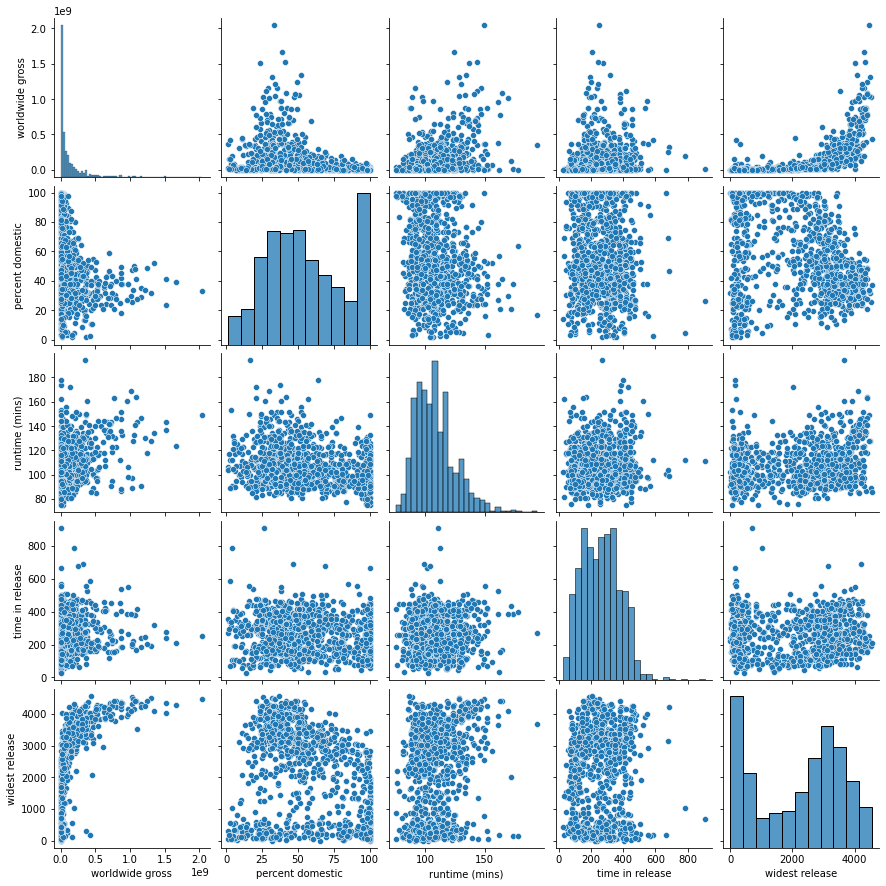

In [196]:
sns.pairplot(train_data)
#what we might take away from this is that high-grossing films tend to be released to many theaters
#high-grossing films also have a moderate degree of international box office sales as a percentage of total gross
#worldwide gross need transformation

In [197]:
train_data.corr()

,worldwide gross,percent domestic,runtime (mins),time in release,widest release
worldwide gross,1.000000,-0.337992,0.353235,0.088444,0.591019
percent domestic,-0.337992,1.000000,-0.217808,-0.094413,-0.237477
runtime (mins),0.353235,-0.217808,1.000000,0.079371,0.235835
time in release,0.088444,-0.094413,0.079371,1.000000,0.045775
widest release,0.591019,-0.237477,0.235835,0.045775,1.000000


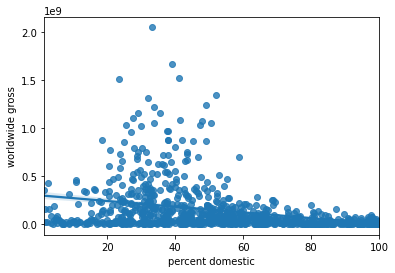

In [199]:
ax = sns.regplot(x=train_data['percent domestic'], y=train_data['worldwide gross'], data=train_data)
#pattern of residuals indicates a nonlinear relationship between percent domestic and worldwide gross

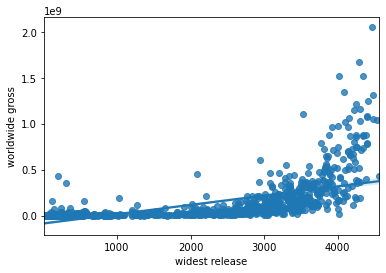

In [200]:
ax = sns.regplot(x=train_data['widest release'], y=train_data['worldwide gross'], data=train_data)
#pattern of residuals indicates a nonlinear relationship between widest release and worldwide gross

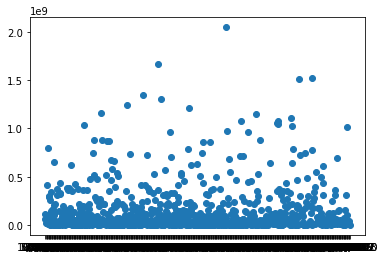

In [221]:
#scatter plot gross by date
#release_date = train_data['release date']
#type(release_date)
#release_date_month = d
plt.scatter(x=train_data['release date'], y=train_data['worldwide gross'])
plt.show()
#release_date does not seem to predict gross

In [208]:
X = train_data['widest release']
X = sm.add_constant(X)
results1 = sm.OLS(endog=train_data['worldwide gross'], exog=X).fit()
print(results1.summary())
#non-normality of errors (fails JB test)
#Durbin-Watson is good (near to 2.0)

                            OLS Regression Results                            
Dep. Variable:        worldwide gross   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     499.8
Date:                Sat, 12 Mar 2022   Prob (F-statistic):           5.93e-89
Time:                        12:04:33   Log-Likelihood:                -19115.
No. Observations:                 933   AIC:                         3.823e+04
Df Residuals:                     931   BIC:                         3.824e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -8.506e+07   1.17e+07     -7.

In [209]:
X = train_data[['widest release', 'percent domestic']]
X = sm.add_constant(X)
results2 = sm.OLS(endog=train_data['worldwide gross'], exog=X).fit()
print(results2.summary())
#adding percent domestic increases Adj R-squared

                            OLS Regression Results                            
Dep. Variable:        worldwide gross   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     298.2
Date:                Sat, 12 Mar 2022   Prob (F-statistic):          8.85e-101
Time:                        12:16:38   Log-Likelihood:                -19084.
No. Observations:                 933   AIC:                         3.817e+04
Df Residuals:                     930   BIC:                         3.819e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.508e+07   1.89e+07  

Log transform the target variable, worldwide gross

In [108]:
worldwide_gross_log = np.log(train_data['worldwide gross'])
train_data["log worldwide gross"] = worldwide_gross_log

In [109]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 933 entries, 823 to 230
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                933 non-null    object 
 1   worldwide gross      933 non-null    int64  
 2   percent domestic     933 non-null    float64
 3   distributor          933 non-null    object 
 4   release date         933 non-null    object 
 5   MPAA rating          933 non-null    object 
 6   runtime (mins)       933 non-null    int64  
 7   genres               933 non-null    object 
 8   time in release      933 non-null    int64  
 9   widest release       933 non-null    int64  
 10  log worldwide gross  933 non-null    float64
dtypes: float64(2), int64(4), object(5)
memory usage: 87.5+ KB


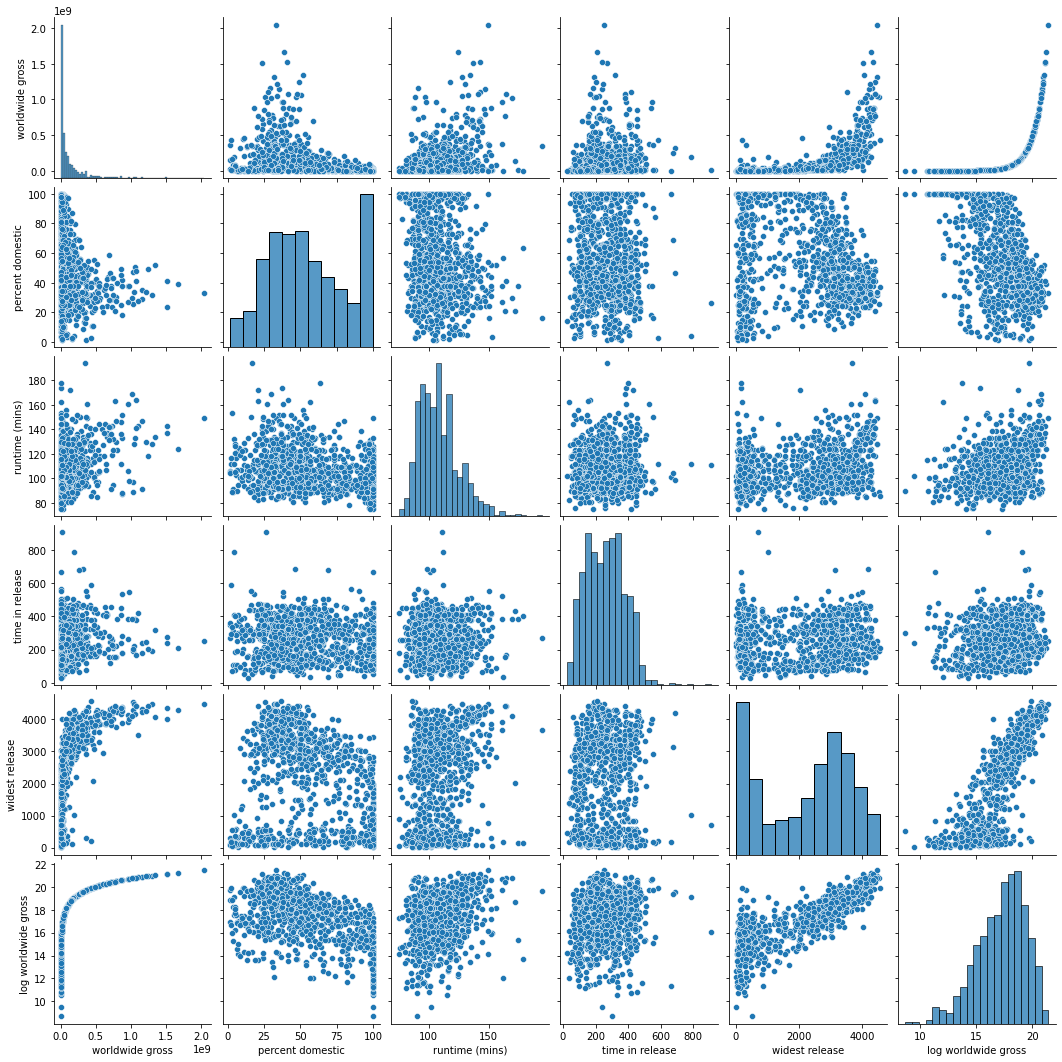

In [239]:
sns.pairplot(train_data)
plt.savefig("pair_plot.png")
#worth noting that log worldwide gross looks somewhat normal
#our two best features, widest release and percent domestic are both bimodal and there is likely some colinearity

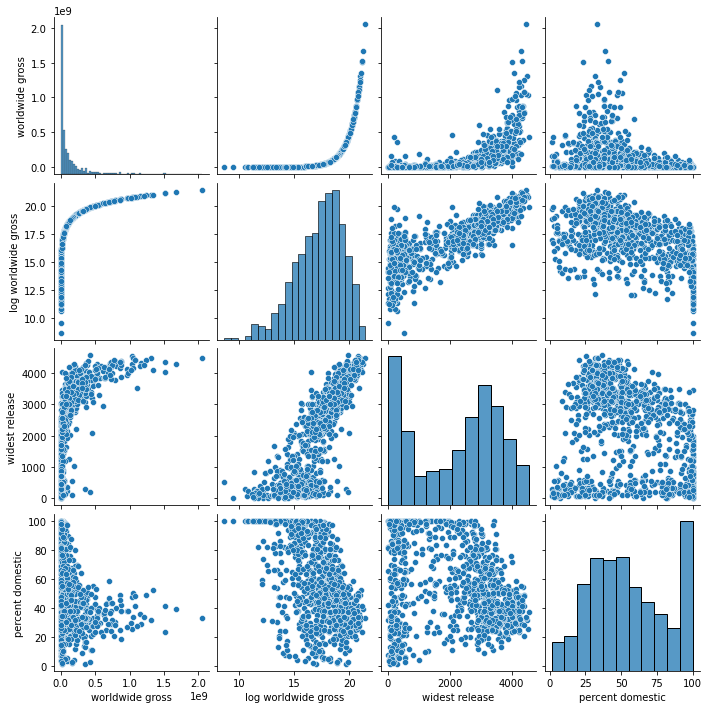

In [182]:
subset = train_data[["worldwide gross", "log worldwide gross", "widest release", "percent domestic"]]
sns.pairplot(subset)
plt.savefig("pair_plot.png")

In [237]:
train_data.corr()
#note the relatively low correlation between percent domestic and widest release
#this might be related to the bimodality of both features

,worldwide gross,percent domestic,runtime (mins),time in release,widest release,log worldwide gross
worldwide gross,1.000000,-0.337992,0.353235,0.088444,0.591019,0.656054
percent domestic,-0.337992,1.000000,-0.217808,-0.094413,-0.237477,-0.514321
runtime (mins),0.353235,-0.217808,1.000000,0.079371,0.235835,0.286683
time in release,0.088444,-0.094413,0.079371,1.000000,0.045775,0.136767
widest release,0.591019,-0.237477,0.235835,0.045775,1.000000,0.829842
log worldwide gross,0.656054,-0.514321,0.286683,0.136767,0.829842,1.000000


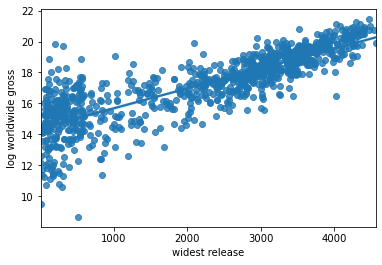

In [229]:
ax = sns.regplot(x=train_data['widest release'], y=train_data['log worldwide gross'], data=train_data)

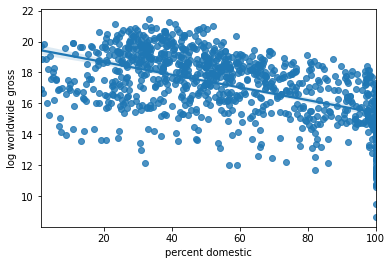

In [230]:
ax = sns.regplot(x=train_data['percent domestic'], y=train_data['log worldwide gross'], data=train_data)

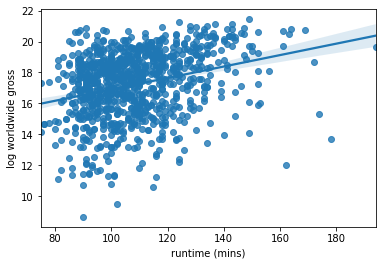

In [228]:
ax = sns.regplot(x=train_data['runtime (mins)'], y=train_data['log worldwide gross'], data=train_data)

In [231]:
X = train_data['widest release']
X = sm.add_constant(X)
results1 = sm.OLS(endog=train_data['log worldwide gross'], exog=X).fit()
print(results1.summary())

                             OLS Regression Results                            
Dep. Variable:     log worldwide gross   R-squared:                       0.689
Model:                             OLS   Adj. R-squared:                  0.688
Method:                  Least Squares   F-statistic:                     2059.
Date:                 Sun, 13 Mar 2022   Prob (F-statistic):          4.11e-238
Time:                         12:20:20   Log-Likelihood:                -1495.8
No. Observations:                  933   AIC:                             2996.
Df Residuals:                      931   BIC:                             3005.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             14.3976      0.0

In [232]:
X = train_data[['widest release', 'percent domestic']]
X = sm.add_constant(X)
results2 = sm.OLS(endog=train_data['log worldwide gross'], exog=X).fit()
print(results2.summary())

                             OLS Regression Results                            
Dep. Variable:     log worldwide gross   R-squared:                       0.795
Model:                             OLS   Adj. R-squared:                  0.795
Method:                  Least Squares   F-statistic:                     1807.
Date:                 Sun, 13 Mar 2022   Prob (F-statistic):          4.66e-321
Time:                         12:21:50   Log-Likelihood:                -1300.1
No. Observations:                  933   AIC:                             2606.
Df Residuals:                      930   BIC:                             2621.
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               16.1515   

In [233]:
X = train_data[['widest release', 'percent domestic', 'runtime (mins)']]
X = sm.add_constant(X)
results3 = sm.OLS(endog=train_data['log worldwide gross'], exog=X).fit()
print(results3.summary())

                             OLS Regression Results                            
Dep. Variable:     log worldwide gross   R-squared:                       0.797
Model:                             OLS   Adj. R-squared:                  0.796
Method:                  Least Squares   F-statistic:                     1214.
Date:                 Sun, 13 Mar 2022   Prob (F-statistic):          8.05e-321
Time:                         12:22:30   Log-Likelihood:                -1296.8
No. Observations:                  933   AIC:                             2602.
Df Residuals:                      929   BIC:                             2621.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               15.5902   

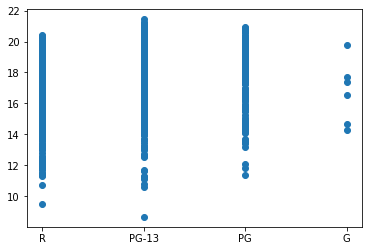

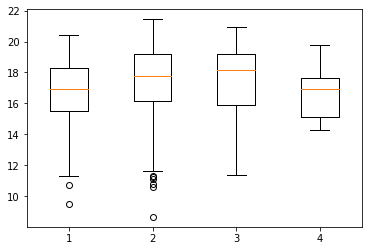

In [5]:
plt.scatter(x=train_data['MPAA rating'], y=train_data['log worldwide gross'])
plt.show()

#train_data['worldwide gross'].mean(axis=0,skipna=True)['MPAA rating']
dfR = train_data[train_data['MPAA rating'] == "R"]
dfPG13 = train_data[train_data['MPAA rating'] == "PG-13"]
dfPG = train_data[train_data['MPAA rating'] == "PG"]
dfG = train_data[train_data['MPAA rating'] == "G"]

box_plot_data=[dfR['log worldwide gross'], dfPG13['log worldwide gross'], dfPG['log worldwide gross'], dfG['log worldwide gross']]
plt.boxplot(box_plot_data)
plt.show()


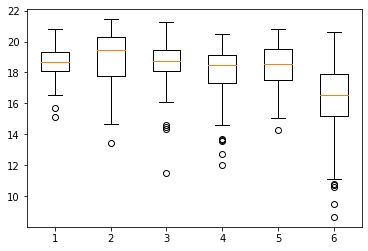

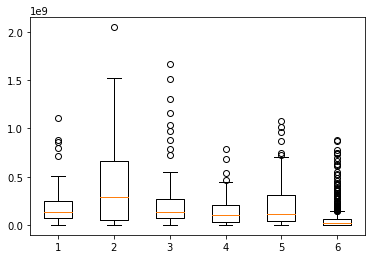

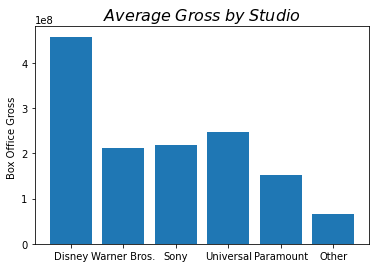

In [197]:
dfSony = train_data[train_data['distributor'] == "Sony Pictures Entertainment (SPE)"]
dfDisney = train_data[train_data['distributor'] == "Walt Disney Studios Motion Pictures"]
dfUniversal = train_data[train_data['distributor'] == "Universal Pictures"]
dfParamount = train_data[train_data['distributor'] == "Paramount Pictures"]
dfWarnerBros = train_data[train_data['distributor'] == "Warner Bros."]

dfOther = train_data.loc[train_data["distributor"] != "Sony Pictures Entertainment (SPE)"]
dfOther = dfOther.loc[dfOther["distributor"] != "Walt Disney Studios Motion Pictures"]
dfOther = dfOther.loc[dfOther["distributor"] != "Universal Pictures"]
dfOther = dfOther.loc[dfOther["distributor"] != "Paramount Pictures"]
dfOther = dfOther.loc[dfOther["distributor"] != "Warner Bros."]

box_plot_data=[dfSony['log worldwide gross'], dfDisney['log worldwide gross'], dfUniversal['log worldwide gross'], 
               dfParamount['log worldwide gross'], dfWarnerBros['log worldwide gross'], dfOther['log worldwide gross'] ]
plt.boxplot(box_plot_data)
plt.show()


box_plot_data=[dfSony['worldwide gross'], dfDisney['worldwide gross'], dfUniversal['worldwide gross'], 
               dfParamount['worldwide gross'], dfWarnerBros['worldwide gross'], dfOther['worldwide gross'] ]
plt.boxplot(box_plot_data)
plt.show()

#Box plots are nice, but hard to read for layperson
#Bar plots of mean gross by studio makes a strong case for Disney
DisneyMean = dfDisney['worldwide gross'].mean()
SonyMean = dfSony['worldwide gross'].mean()
UniversalMean = dfUniversal['worldwide gross'].mean()
ParamountMean = dfParamount['worldwide gross'].mean()
WarnerBrosMean = dfWarnerBros['worldwide gross'].mean()
OtherMean = dfOther['worldwide gross'].mean()
studios = ['Disney','Warner Bros.', 'Sony', 'Universal', 'Paramount', 'Other']
means = [DisneyMean, WarnerBrosMean, SonyMean, UniversalMean, ParamountMean, OtherMean]

plt.bar(x=studios, height=means)
plt.title('$Average\; Gross\; by \; Studio$', fontsize=16)
plt.ylabel("Box Office Gross ");
plt.savefig("Disney_studio_gross.png")

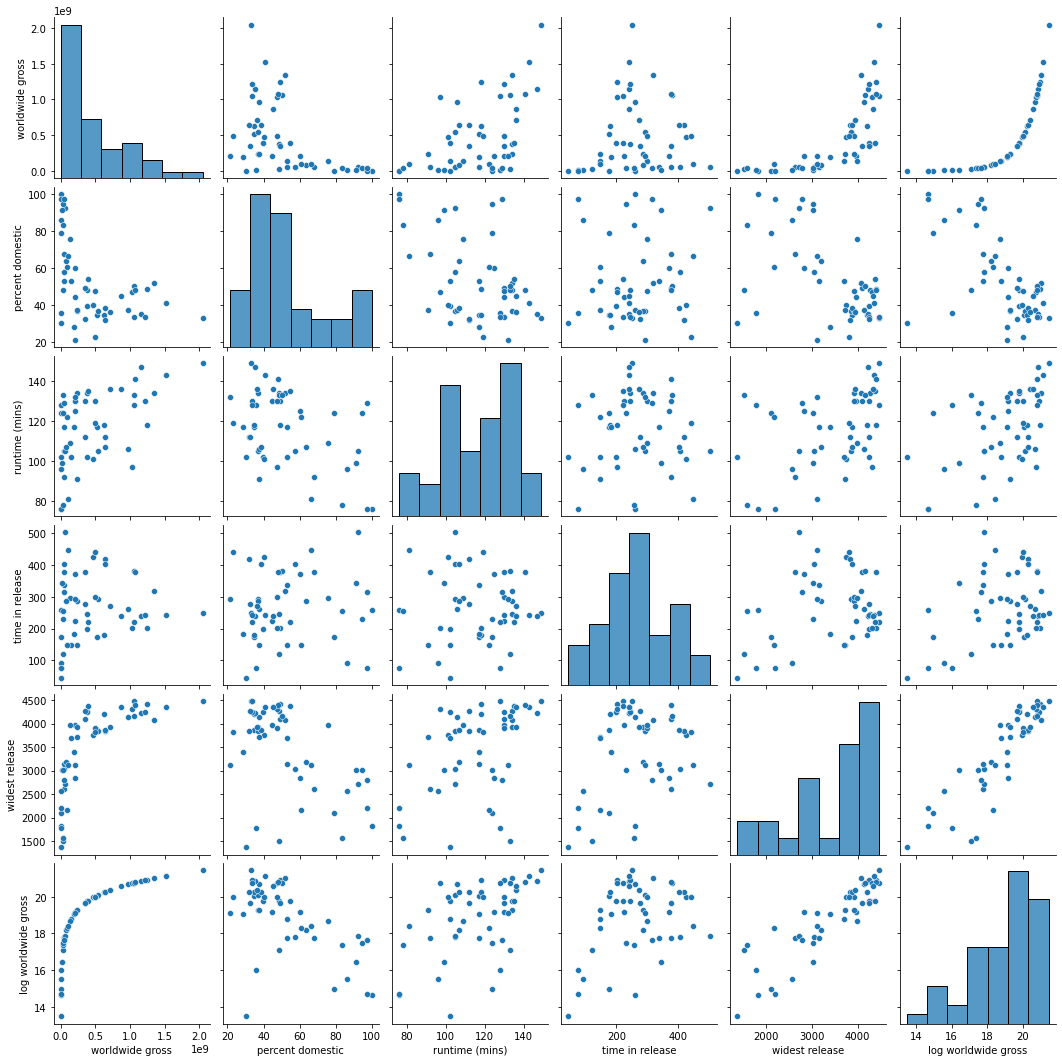

In [110]:
dfDisney = train_data[train_data['distributor'] == "Walt Disney Studios Motion Pictures"]
dfNotDisney = train_data.loc[train_data["distributor"] != "Walt Disney Studios Motion Pictures"]

#display(dfDisney)
sns.pairplot(dfDisney)

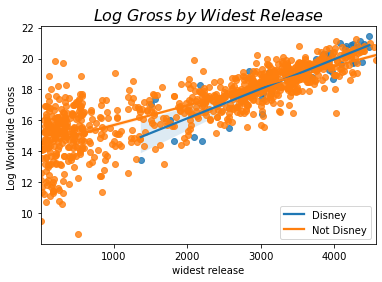

In [199]:
ax = sns.regplot(x=dfDisney['widest release'], y=dfDisney['log worldwide gross'], data=dfDisney)
ax = sns.regplot(x=dfNotDisney['widest release'], y=dfNotDisney['log worldwide gross'], data=dfNotDisney)
plt.title('$Log\; Gross\; by \; Widest\; Release$', fontsize=16)
plt.ylabel("Log Worldwide Gross ");
plt.legend(loc="lower right", labels=["Disney","Not Disney"])
plt.savefig("Disney_widest_release.png")

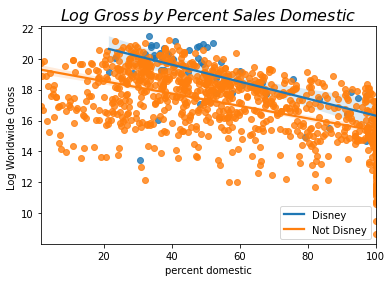

In [196]:
ax = sns.regplot(x=dfDisney['percent domestic'], y=dfDisney['log worldwide gross'], data=dfDisney)
ax = sns.regplot(x=dfNotDisney['percent domestic'], y=dfNotDisney['log worldwide gross'], data=dfNotDisney)
plt.title('$Log\; Gross\; by \; Percent\; Sales\; Domestic$', fontsize=16)
plt.ylabel("Log Worldwide Gross ");
plt.legend(loc="lower right", labels=["Disney","Not Disney"])
plt.savefig("Disney_percent_domestic.png")

In [65]:
#engineer Disney feature as new column
train_data['disney'] = (train_data['distributor'] == "Walt Disney Studios Motion Pictures").astype(int)

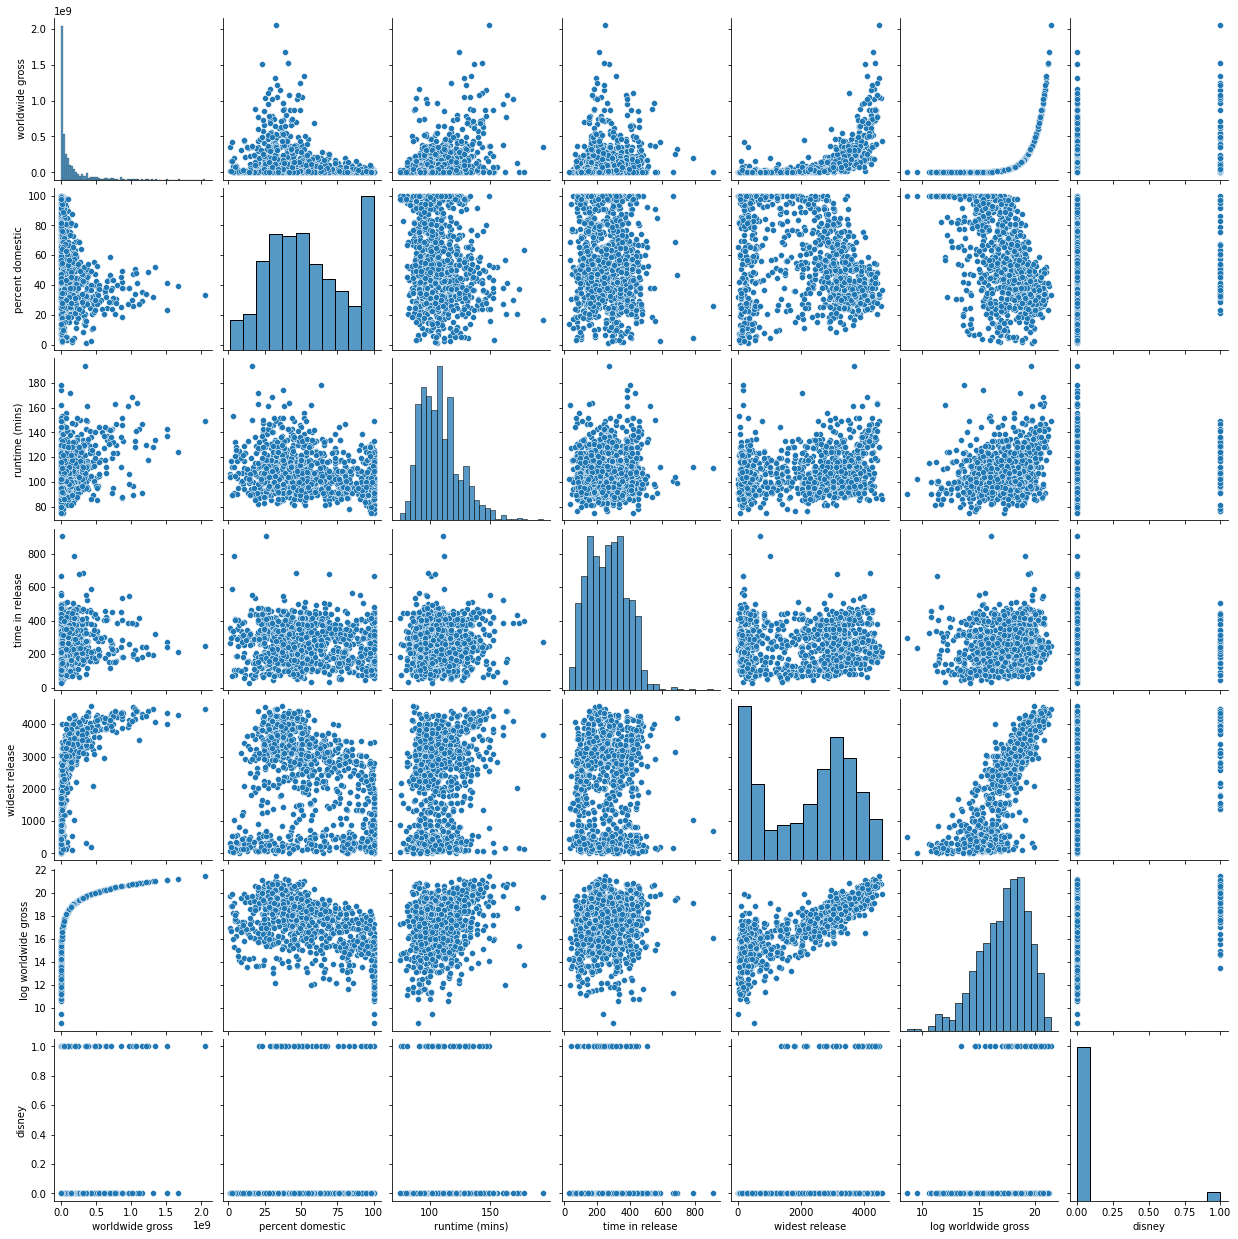

In [88]:
sns.pairplot(train_data)

In [115]:
X = train_data[['widest release', 'percent domestic']]
X = sm.add_constant(X)
results4 = sm.OLS(endog=train_data['log worldwide gross'], exog=X).fit()
print(results4.summary())

                             OLS Regression Results                            
Dep. Variable:     log worldwide gross   R-squared:                       0.795
Model:                             OLS   Adj. R-squared:                  0.795
Method:                  Least Squares   F-statistic:                     1807.
Date:                 Thu, 17 Mar 2022   Prob (F-statistic):          4.66e-321
Time:                         13:37:44   Log-Likelihood:                -1300.1
No. Observations:                  933   AIC:                             2606.
Df Residuals:                      930   BIC:                             2621.
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               16.1515   

In [69]:
X = train_data[['widest release', 'percent domestic', 'disney']]
X = sm.add_constant(X)
results4 = sm.OLS(endog=train_data['log worldwide gross'], exog=X).fit()
print(results4.summary())

                             OLS Regression Results                            
Dep. Variable:     log worldwide gross   R-squared:                       0.796
Model:                             OLS   Adj. R-squared:                  0.795
Method:                  Least Squares   F-statistic:                     1205.
Date:                 Mon, 14 Mar 2022   Prob (F-statistic):          1.09e-319
Time:                         17:57:56   Log-Likelihood:                -1299.4
No. Observations:                  933   AIC:                             2607.
Df Residuals:                      929   BIC:                             2626.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               16.1583   

In [168]:
lr_model_lasso = sklearn.linear_model.Lasso(alpha = 0.1)
lr_model_lasso.fit(train_data[['widest release', 'percent domestic']], y=train_data['log worldwide gross'])
lr_model_lasso.score(train_data[['widest release', 'percent domestic']], y=train_data['log worldwide gross'])

0.7952986255712238

In [ ]:


#Testing



In [170]:
log_test = np.log(test_data['worldwide gross'])
log_test

1496    17.451265
168     18.932312
353     17.584748
468     19.358675
1410    19.815326
          ...    
1524    14.356671
58      17.341630
1522    16.135315
1034    15.958825
1201    16.176993
Name: worldwide gross, Length: 312, dtype: float64

In [ ]:
#struggling to apply log to test data

#worldwide_gross_log = np.log(test_data['worldwide gross'])
#test_data["log worldwide gross"] = worldwide_gross_log

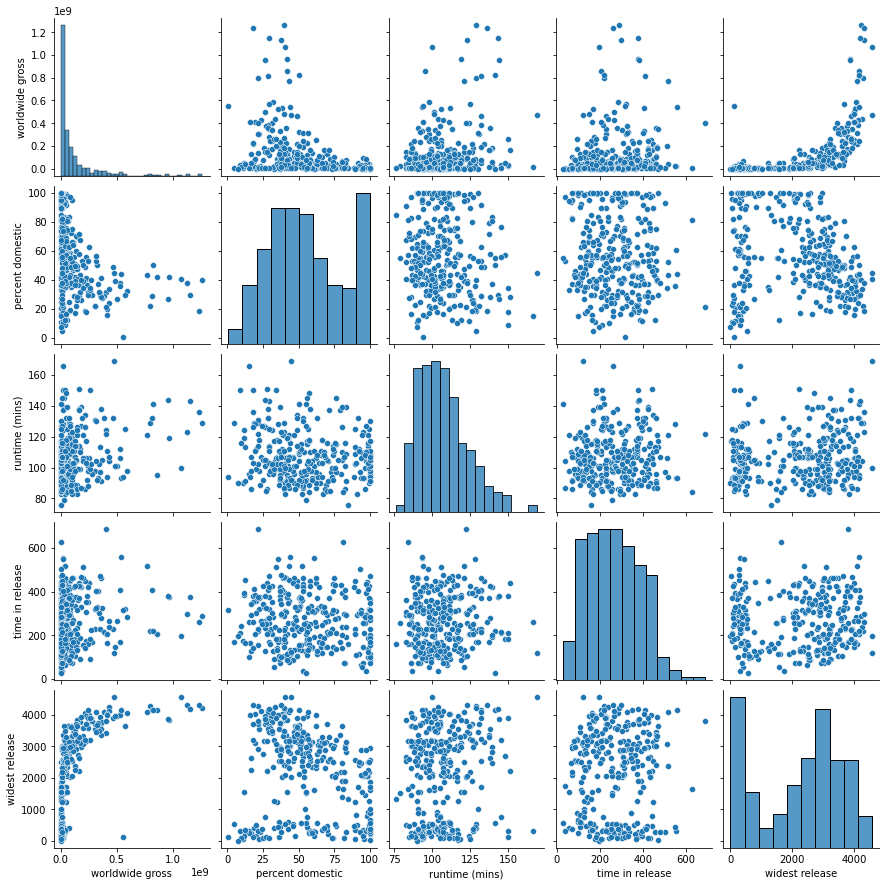

In [90]:
sns.pairplot(test_data)

In [114]:
m = LinearRegression()
m.fit(train_data[['widest release', 'percent domestic']], y=train_data['log worldwide gross'])
m.score(train_data[['widest release', 'percent domestic']], y=train_data['log worldwide gross'])
m.score(train_data[['widest release', 'percent domestic']], y=train_data['log worldwide gross'])
m.score(test_data[['widest release', 'percent domestic']], y=np.log(test_data['worldwide gross']))


0.8047808983612481

In [176]:
#Mean Squared Logarithmic Error (MSLE)

y_true = np.log(test_data['worldwide gross'])
y_pred = m.predict(test_data[['widest release', 'percent domestic']])
mean_squared_log_error(y_true, y_pred)

0.0029957067165541826